<a href="https://colab.research.google.com/github/broskey40/Phylogenetic-Tree/blob/main/Phylogenetic_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Biopython

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 230.9 kB/s eta 0:00:33
   -- -------------------

# Phylogenetic Tree code with User Input


--- FASTA File Input ---
File path diterima: C:\Users\Variel\OneDrive\Desktop\DNA Sequence\sequences (1).fasta

Proses pemuatan urutan dimulai...
Berhasil memuat 103 urutan untuk analisis.
Menghitung matriks jarak menggunakan Biopython Pairwise Alignment...
Secara otomatis menentukan urutan tampilan yang optimal...
--- Analisis UPGMA Selesai ---
Jumlah urutan yang digunakan: 103
String Newick (menggunakan nama spesies lengkap):
 ((|Dengue virus type 1 strain ThD1_K0407_01 envelope protein (E) gene, partial cds:0.028039,((|Dengue virus 1 isolate DPS-032 polyprotein, envelope protein E region, (POLY) gene, partial cds:0.004209,(|Dengue virus type I isolate DV1I-TM19-17 polyprotein, envelope protein E region, (POLY) gene, partial cds:0.003535,(|Dengue virus 1 isolate DPS-031 polyprotein, envelope protein E region, (POLY) gene, partial cds:0.003030,|Dengue virus type 1 isolate 3034/D1/Penang/2019 polyprotein, envelope prote...

Menghasilkan pohon filogenetik yang SECARA OTOMATIS DIURUTKAN

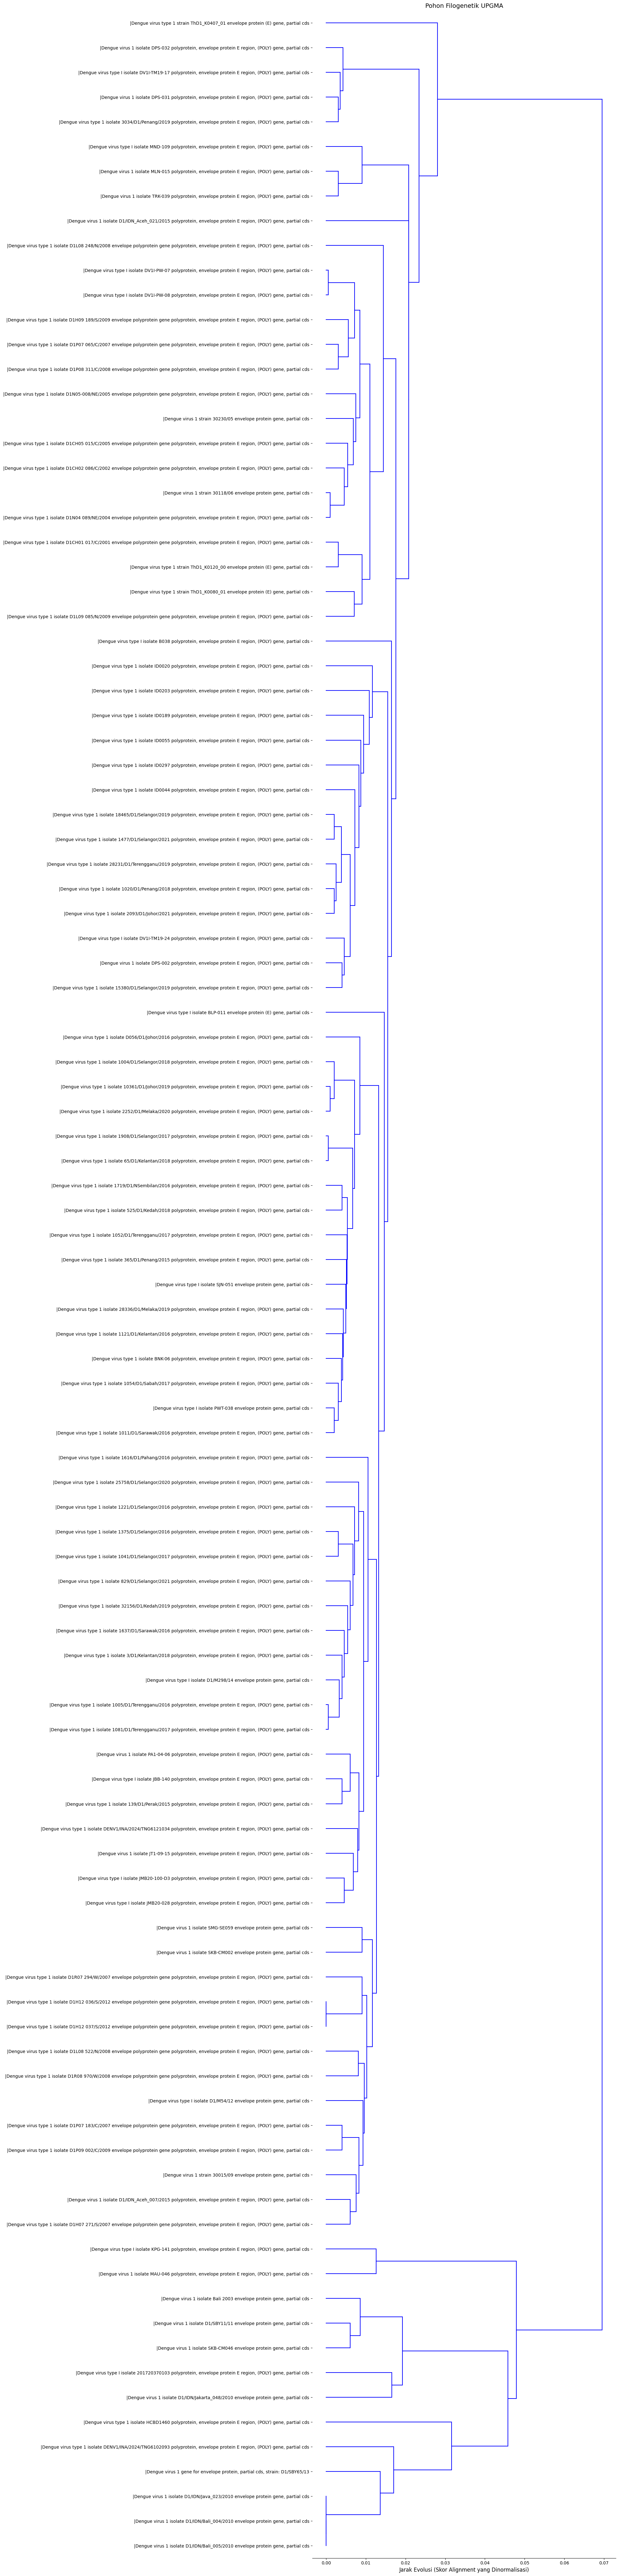

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from typing import List, Tuple, Dict, Any, Union
from Bio import Align

# --- 1. Global Aligner ---

# Digunakan Bio.Align.PairwiseAligner
aligner = Align.PairwiseAligner()
aligner.mode = 'global'

# Match: +2, Mismatch: -1, Gap Open: -5, Gap Extend: -0.5
aligner.match_score = 2.0
aligner.mismatch_score = -1.0
aligner.open_gap_score = -5.0
aligner.extend_gap_score = -0.5


# --- User Input ---

def get_user_file_path() -> str:
    """
    Akan meminta user untuk menginput file FASTA tunggal yang akan di-align.
    """
    print("\n--- FASTA File Input ---")

    # Meminta user untuk meng-input file
    user_input = input(
        """
        Masukkan path file FASTA tunggal yang berisi banyak sekuens:\n>
        """
    )

    file_path = user_input.strip()

    if file_path:
        print(f"File path diterima: {file_path}")
    else:
        print("Tidak ada file path yang dimasukkan.")

    return file_path


# --- 2. Unduh Data dan Parsing ---

def parse_fasta_multisequence(file_path: str, species_names_map: Dict[str, str]) -> Tuple[List[str], List[str], List[str]]:
    """
    Membaca file FASTA yang berisi multiple sequences dan mengambil Accession ID,
    sequence, dan header untuk setiap sequence.
    Menggunakan species_names_map untuk melabeli jika tersedia,
    atau menggunakan bagian dari header/nama file.
    """
    seq_ids: List[str] = []
    species_labels: List[str] = []
    seqs: List[str] = []

    try:
        with open(file_path, 'r') as f:
            content = f.read().strip()
    except FileNotFoundError:
        print(f"Error: File tidak ada di {file_path}. Lewatkan.")
        return [], [], []

    entries = content.split('>')
    # Remove the first empty entry if the file starts with '>'
    if entries[0] == '':
        entries = entries[1:]

    for entry in entries:
        lines = entry.strip().split('\n')
        if not lines:
            continue

        header = lines[0].strip()
        sequence = "".join(lines[1:]).replace('\n', '').replace(' ', '').upper()

        if not sequence:
            # Skip entries with no sequence
            continue

        match = re.search(r'^(\S+)', header)
        seq_id = match.group(1) if match else header.split()[0] if header else "Unknown_ID"

        # Final Display Label
        label = species_names_map.get(seq_id)

        if not label:
             # Try to get label from header description
            header_parts = header.split(maxsplit=1)
            if len(header_parts) > 1:
                label = header_parts[1].strip()
            else:
                # Fallback to a truncated ID or file part if no good label found
                label = seq_id # Use seq_id if header description is empty

        seq_ids.append(seq_id)
        species_labels.append(label)
        seqs.append(sequence)

    return seq_ids, species_labels, seqs


# --- 3. UPGMA Core Logic ---
# Algoritma UPGMA (Unweighted Pair Group Method with Arithmetic Mean).
# Secara iteratif menggabungkan dua cluster terdekat (berdasarkan 'dist_mat').
# Jarak cluster baru ke cluster lain dihitung menggunakan RATA-RATA BERBOBOT
# (sesuai ukuran/jumlah sekuens dalam cluster).
# Asumsi 'Molecular Clock' (laju evolusi konstan) diterapkan: kedalaman node = Jarak_Min / 2.

def calculate_normalized_score(s1: str, s2: str) -> float:
    """
    Menghitung skor similaritas yang ternormalisasi (0.0 hingga 1.0).
    Skor mentah dibagi dengan skor maksimum teoritis (panjang_min * match_score).
    """
    if not s1 or not s2:
        return 0.0

    raw_score = aligner.score(s1, s2)
    s_min = min(s1, s2, key=len)
    max_score = len(s_min) * aligner.match_score

    if max_score <= 0:
        # Handle cases where max_score is non-positive (e.g., zero length sequences)
        return 0.0

    normalized_similarity = raw_score / max_score
    # Memastikan skor minimal 0.0
    return max(0.0, normalized_similarity)

def compute_distance_matrix(seqs: List[str]) -> np.ndarray:
    """
    Menghitung matriks jarak berpasangan (pairwise distance matrix).
    Jarak dihitung sebagai: Jarak = 1.0 - Similaritas_Normalisasi.
    """
    n = len(seqs)
    dist_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            similarity = calculate_normalized_score(seqs[i], seqs[j])
            dist = 1.0 - similarity
            dist_mat[i, j] = dist_mat[j, i] = dist
    return dist_mat

def perform_upgma(dist_mat: np.ndarray,
                  labels: List[str]) -> Tuple[np.ndarray, List[Any], str,
                                              Dict[int, Tuple[float, float]],
                                              Dict[Tuple[int, int], float],
                                              Dict[Any, int],
                                              Dict[int, List[int]], int]:
    """
    Menerapkan algoritma UPGMA.
    Secara iteratif menggabungkan cluster terdekat dan menghitung ulang jarak
    menggunakan rata-rata berbobot.
    Mencatat posisi node (untuk plotting) dan menghasilkan string Newick.
    """
    n = len(labels)
    clusters = {i: labels[i] for i in range(n)}
    sizes = {i: 1 for i in range(n)}
    dists = {}
    for i in range(n):
        for j in range(i + 1, n):
            dists[(i, j)] = dist_mat[i, j]

    next_idx = n
    merge_history = []
    node_positions = {i: (0.0, float(i)) for i in range(n)}
    y_coords = {i: float(i) for i in range(n)}
    newick_parts = {i: labels[i] for i in range(n)}
    branch_lengths = {}
    parent_child_map: Dict[int, List[int]] = {}

    def get_dist(a, b):
        if a == b: return 0.0
        key = (a, b) if a < b else (b, a)
        return dists.get(key, float('inf'))

    while len(clusters) > 1:
        try:
            # Safely find the minimum distance pair
            pair, mind = min(dists.items(), key=lambda x: x[1])
        except ValueError:
            # No more pairs to merge
            break

        a, b = pair
        size_a, size_b = sizes[a], sizes[b]

        remaining_clusters_indices = [k for k in clusters.keys() if k not in (a, b)]
        new_dists = {}

        for other in remaining_clusters_indices:
            da = get_dist(a, other)
            db = get_dist(b, other)
            # UPGMA: Rata-rata berbobot untuk menghitung jarak ke cluster lain
            # Avoid division by zero if somehow sizes are zero (shouldn't happen with size init)
            if (size_a + size_b) > 0:
                 newd = (da * size_a + db * size_b) / (size_a + size_b)
            else:
                 newd = float('inf') # Cannot merge, treat as infinite distance

            new_idx_candidate = next_idx
            key = (other, new_idx_candidate) if other < new_idx_candidate else (new_idx_candidate, other)
            new_dists[key] = newd

        keys_to_remove = [k for k in dists.keys() if a in k or b in k]
        for k in keys_to_remove: del dists[k]

        new_idx = next_idx
        next_idx += 1

        # Kedalaman node (Molecular Clock): setengah dari jarak minimum
        parent_x = mind / 2.0

        y_a = y_coords[a]
        y_b = y_coords[b]
        parent_y = (y_a + y_b) / 2.0

        # Panjang cabang
        branch_len_a = parent_x - node_positions[a][0]
        branch_len_b = parent_x - node_positions[b][0]

        merge_history.append((clusters[a], clusters[b], mind))
        node_positions[new_idx] = (parent_x, parent_y)
        branch_lengths[(new_idx, a)] = branch_len_a
        branch_lengths[(new_idx, b)] = branch_len_b
        y_coords[new_idx] = parent_y

        parent_child_map[new_idx] = [a, b]

        # Membuat string Newick
        newick_a = f"{newick_parts[a]}:{branch_len_a:.6f}"
        newick_b = f"{newick_parts[b]}:{branch_len_b:.6f}"

        new_cluster_newick = f"({newick_a},{newick_b})"

        newick_parts[new_idx] = new_cluster_newick
        clusters[new_idx] = new_cluster_newick
        sizes[new_idx] = size_a + size_b
        dists.update(new_dists)

        del clusters[a]; del clusters[b]; del sizes[a]; del sizes[b]

    # After the loop, if there's exactly one cluster left, that's the root
    final_key = list(clusters.keys())[0] if clusters else None
    final_newick = newick_parts[final_key] + ";" if final_key is not None else ""


    final_y_coords = {labels[i]: y_coords[i] for i in range(n)}
    # Also add internal node Y coordinates if they exist
    for k, v in y_coords.items():
        if k >= n: # Internal nodes start from index n
            final_y_coords[k] = v


    return dist_mat, merge_history, final_newick, node_positions, branch_lengths, final_y_coords, parent_child_map, final_key


def get_automatic_order(root_key: int, labels: List[str], parent_child_map: Dict[int, List[int]], node_positions: Dict[int, Tuple[float, float]]) -> List[str]:
    """
    Melakukan traversal (penelusuran) pohon dari akar untuk menentukan urutan
    daun (leaf order) yang optimal untuk visualisasi (untuk menghindari tumpang tindih).
    Prioritas urutan didasarkan pada posisi X node (kedalaman evolusi).
    """
    leaf_order: List[str] = []
    n = len(labels)

    # Handle case with less than 2 leaves (no tree structure)
    if n < 2:
         return labels # Return original labels as order

    def traverse(node_idx: int):
        if node_idx < n:
            # It's a leaf node
            if node_idx < len(labels): # Ensure index is within bounds
                 leaf_order.append(labels[node_idx])
            return

        # It's an internal node
        children = parent_child_map.get(node_idx)
        if not children or len(children) != 2:
             # Handle cases where an internal node doesn't have exactly two children (shouldn't happen in UPGMA normally, but for safety)
            for child in children:
                 traverse(child)
            return


        child1, child2 = children

        # Menggunakan posisi X (kedalaman evolusi) untuk menentukan urutan kiri/kanan
        # Add checks for child nodes existing in node_positions
        pos1 = node_positions.get(child1, (float('inf'), float('inf')))[0]
        pos2 = node_positions.get(child2, (float('inf'), float('inf')))[0]


        if pos1 > pos2:
            left, right = child1, child2
        else:
            left, right = child2, child1

        # Recursively traverse children
        traverse(left)
        traverse(right)

    traverse(root_key)
    return leaf_order


# --- 4. Plotting ---

def plot_tree(labels: List[str], node_positions, branch_lengths,
              automatic_order: List[str], zoom_x_limit: float = None):
    """
    Menghasilkan visualisasi pohon filogenetik (dendrogram) menggunakan Matplotlib.
    Menggunakan 'automatic_order' untuk mengatur sumbu Y daun secara bersih.
    """
    fig, ax = plt.subplots(figsize=(10, max(5, len(labels) * 0.8)))

    # 1. Buat pemetaan baru dan terurut dari nama spesies ke koordinat Y secara berurut
    reordered_y_map = {species: float(i) for i, species in enumerate(automatic_order)}

    # 2. Hitung posisi Y untuk node internal berdasarkan posisi Y yang baru
    n = len(labels)
    temp_y_map = {i: reordered_y_map[labels[i]] for i in range(n)}
    internal_node_indices = sorted([k for k in node_positions.keys() if k >= n])

    for current_parent_idx in internal_node_indices:
        # Find children by looking for branch_lengths keys where parent is current_parent_idx
        children = [child for (parent, child) in branch_lengths.keys() if parent == current_parent_idx]


        if len(children) == 2:
            child_a, child_b = children
            y_a = temp_y_map.get(child_a)
            y_b = temp_y_map.get(child_b)

            if y_a is not None and y_b is not None:
                new_y = (y_a + y_b) / 2.0
                temp_y_map[current_parent_idx] = new_y
        elif len(children) == 1:
             # Handle case with only one child (should not happen in UPGMA, but for safety)
             child_a = children[0]
             y_a = temp_y_map.get(child_a)
             if y_a is not None:
                  temp_y_map[current_parent_idx] = y_a


    final_y_coords = temp_y_map

    # 3. Plotting

    if node_positions:
        # Find the maximum x-coordinate from node positions, which represents the total tree depth
        max_dist = max(pos[0] for pos in node_positions.values())
    else:
        # Default max_dist if no nodes were created (e.g., less than 2 sequences)
        max_dist = 1.0


    # Plot label daun (leaf labels)
    for species_name, y_pos in reordered_y_map.items():
        # Check if species_name exists in final_y_coords before plotting
        if species_name in final_y_coords:
            ax.text(0, y_pos, species_name, va='center', ha='right', fontsize=10)


    # Plot cabang (branches)
    for (parent_node, child_node), length in branch_lengths.items():
        # Get X positions (distance, unchanged) - Use .get with a default value
        parent_x, _ = node_positions.get(parent_node, (0.0, 0.0))
        child_x, _ = node_positions.get(child_node, (0.0, 0.0))

        # Get NEW Y positions (reordered) - Use .get with a default value
        parent_y = final_y_coords.get(parent_node)
        child_y = final_y_coords.get(child_node)

        # Only plot if both parent and child Y coordinates were found
        if parent_y is not None and child_y is not None:
            # Segmen Horizontal (panjang cabang)
            ax.plot([child_x, parent_x], [child_y, child_y], color='blue', linewidth=1.5)
            # Segmen Vertikal (menghubungkan anak-anak)
            ax.plot([parent_x, parent_x], [child_y, parent_y], color='blue', linewidth=1.5)

    ax.set_yticks([])
    ax.set_xlabel("Jarak Evolusi (Skor Alignment yang Dinormalisasi)", fontsize=12)

    # Set title based on zoom level
    if zoom_x_limit is None:
        title = "Pohon Filogenetik UPGMA"
        # Use calculated max_dist if no zoom limit
        plot_max_x = max_dist
    else:
        title = f"Pohon Filogenetik UPGMA (Diperbesar ke Jarak {zoom_x_limit})"
        # Use zoom_x_limit if provided
        plot_max_x = zoom_x_limit


    ax.set_title(title, fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='x', labelsize=10)

    # Atur batas sumbu X untuk memastikan label yang berposisi kanan terlihat
    # Ensure x-limits are valid
    if plot_max_x > 0:
         ax.set_xlim(-plot_max_x * 0.05, plot_max_x * 1.05)
    else:
         # Handle case where max_dist is 0 (e.g., all sequences are identical or only one sequence)
         ax.set_xlim(-0.1, 1.0) # Set a default small range


    # Atur batas sumbu Y berdasarkan jumlah urutan
    ax.set_ylim(-0.5, len(automatic_order) - 0.5)
    plt.tight_layout()

    # Add labels to the y-axis using the automatic_order
    ax.set_yticks(np.arange(len(automatic_order)))
    ax.set_yticklabels(automatic_order)


    plt.show()


def truncate_newick_string(newick_string: str, max_length: int = 500) -> str:
    """Truncates a Newick string if it exceeds a maximum length."""
    if len(newick_string) > max_length:
        return newick_string[:max_length] + "..."
    return newick_string


# --- 5. EKSEKUSI PROGRAM ---

# 1. Meminta input path file dari pengguna
user_file_path = get_user_file_path()

if not user_file_path:
    print("Tidak ada file yang dimasukkan. Analisis dihentikan.")
else:
    # Mendefinisikan dictionary pemetaan nama spesies (opsional).
    # Gunakan dictionary kosong ({}) jika label otomatis dari header FASTA ingin dipertahankan.
    custom_species_map: Dict[str, str] = {}

    # 2. Memuat data secara dinamis dari file tunggal
    print("\nProses pemuatan urutan dimulai...")
    # Memuat ID aksesi, label spesies, dan urutan
    accession_ids, species_labels, seqs = parse_fasta_multisequence(user_file_path, custom_species_map)

    if len(seqs) >= 2:
        print(f"Berhasil memuat {len(seqs)} urutan untuk analisis.")
        print("Menghitung matriks jarak menggunakan Biopython Pairwise Alignment...")

        # 3. Menghitung matriks jarak
        dist_mat = compute_distance_matrix(seqs)

        # 4. Melaksanakan UPGMA
        # Ensure perform_upgma is called with the correct number of arguments
        results = perform_upgma(dist_mat, species_labels)
        # Unpack results - check if results has enough elements
        if len(results) == 8:
             dist_mat_out, merge_history, newick, node_positions, branch_lengths, original_y_coords, parent_child_map, root_key = results
        else:
             print("Error: UPGMA analysis failed to produce expected results.")
             # Handle this error case - perhaps exit or provide an informative message
             dist_mat_out, merge_history, newick, node_positions, branch_lengths, original_y_coords, parent_child_map, root_key = None, None, "", {}, {}, {}, {}, None # Assign default or empty values

        if root_key is not None and parent_child_map is not None and node_positions is not None:
             # 5. TAHAP PENGURUTAN ULANG OTOMATIS
            print("Secara otomatis menentukan urutan tampilan yang optimal...")
            automatic_order = get_automatic_order(root_key, species_labels, parent_child_map, node_positions)

            print("--- Analisis UPGMA Selesai ---")
            print(f"Jumlah urutan yang digunakan: {len(seqs)}")
            # Print the truncated Newick string
            print("String Newick (menggunakan nama spesies lengkap):\n", truncate_newick_string(newick))

            # 6. Membuat plot
            print("\nMenghasilkan pohon filogenetik yang SECARA OTOMATIS DIURUTKAN ULANG...")
            plot_tree(species_labels, node_positions, branch_lengths, automatic_order, zoom_x_limit=None)
        else:
            print("UPGMA did not complete successfully, skipping plotting.")


    else:
        print("Eksekusi gagal: Tidak dapat memuat cukup urutan valid (minimum 2) dari file yang disediakan.")

# Phylogenetic Tree code with MSA

In [8]:
# Replace the previous apt-get install cell with this cross-platform helper.
import shutil
import subprocess
import sys

def ensure_clustalw():
    # Check common executable names
    candidates = ['clustalw', 'clustalw2', 'clustalo']
    for c in candidates:
        if shutil.which(c):
            print(f"Found '{c}' in PATH — ready to use.")
            return True

    print("Clustal executable not found in PATH.")

    # Try installing via conda/mamba if available
    installer = None
    if shutil.which('mamba'):
        installer = ['mamba', 'install', '-c', 'bioconda', 'clustal-w', '-y']
    elif shutil.which('conda'):
        installer = ['conda', 'install', '-c', 'bioconda', 'clustal-w', '-y']

    if installer:
        print("Attempting to install ClustalW via:", ' '.join(installer))
        try:
            subprocess.check_call(installer)
            print("Conda installation finished. Restart the kernel if required.")
            return True
        except subprocess.CalledProcessError:
            print("Conda/mamba installation failed. See message above.")

    # Platform-specific guidance for Windows users
    if sys.platform.startswith('win'):
        print("\nWindows detected. Install ClustalW using one of these options:")
        print("  1) Using conda (recommended if you have Anaconda/Miniconda):")
        print("       conda install -c bioconda clustal-w")
        print("  2) Using Chocolatey (requires admin):")
        print("       choco install clustalw")
        print("  3) Download installer from the official site and add executable to PATH:")
        print("       https://www.clustal.org/clustal2/\n")
    else:
        print("\nNon-Debian Linux / macOS: use your system package manager or conda.")
        print("Examples:")
        print("  macOS (brew): brew install clustal-w")
        print("  conda: conda install -c bioconda clustal-w")

    return False

# Call the helper to inform user and possibly install
_installed = ensure_clustalw()
if not _installed:
    print("MSA step will attempt to run but may fail if ClustalW is not available. You can skip MSA or install ClustalW as instructed above.")

Clustal executable not found in PATH.

Windows detected. Install ClustalW using one of these options:
  1) Using conda (recommended if you have Anaconda/Miniconda):
       conda install -c bioconda clustal-w
  2) Using Chocolatey (requires admin):
       choco install clustalw
  3) Download installer from the official site and add executable to PATH:
       https://www.clustal.org/clustal2/

MSA step will attempt to run but may fail if ClustalW is not available. You can skip MSA or install ClustalW as instructed above.


Streaming output truncated to the last 5000 lines.
Sequences (4:81) Aligned. Score:  90
Sequences (4:82) Aligned. Score:  90
Sequences (4:83) Aligned. Score:  91
Sequences (4:84) Aligned. Score:  90
Sequences (4:85) Aligned. Score:  90
Sequences (4:86) Aligned. Score:  90
Sequences (4:87) Aligned. Score:  91
Sequences (4:88) Aligned. Score:  90
Sequences (4:89) Aligned. Score:  90
Sequences (4:90) Aligned. Score:  90
Sequences (4:91) Aligned. Score:  90
Sequences (4:92) Aligned. Score:  91
Sequences (4:93) Aligned. Score:  90
Sequences (4:94) Aligned. Score:  90
Sequences (4:95) Aligned. Score:  90
Sequences (4:96) Aligned. Score:  90
Sequences (4:97) Aligned. Score:  90
Sequences (4:98) Aligned. Score:  90
Sequences (4:99) Aligned. Score:  90
Sequences (4:100) Aligned. Score:  91
Sequences (4:101) Aligned. Score:  90
Sequences (4:102) Aligned. Score:  90
Sequences (4:103) Aligned. Score:  90
Sequences (5:6) Aligned. Score:  90
Sequences (5:7) Aligned. Score:  91
Sequences (5:8) Aligne

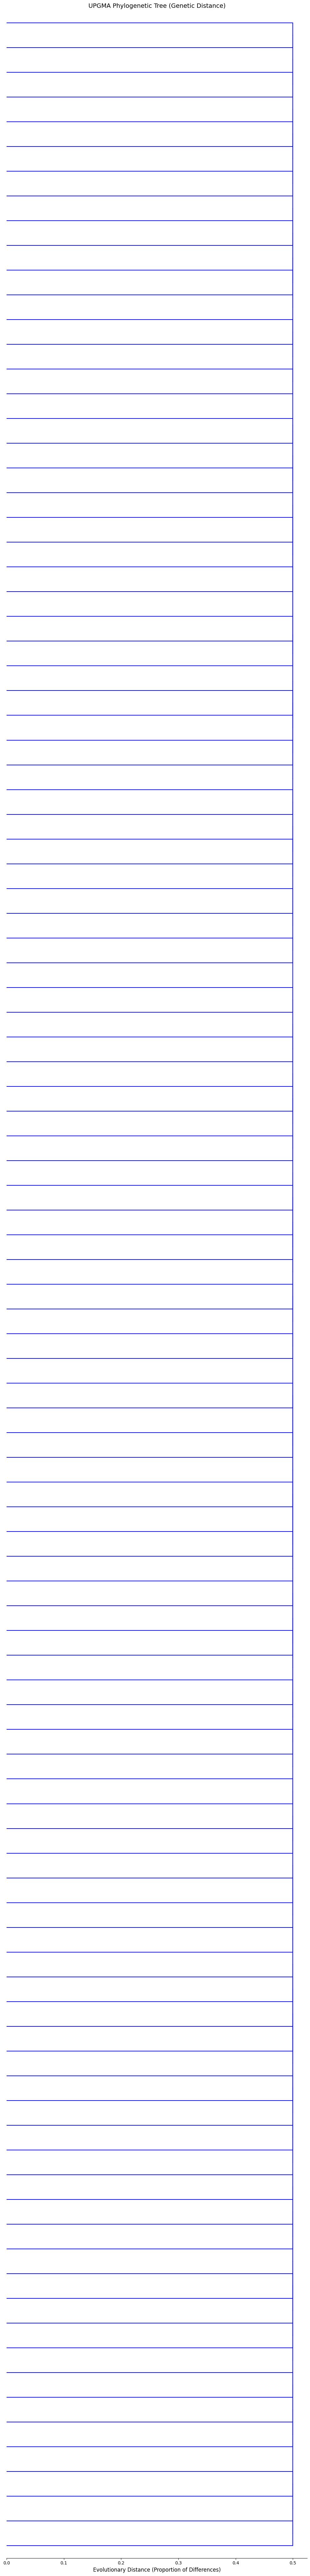

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import subprocess
import tempfile
from typing import List, Tuple, Dict, Any, Union
from Bio import Align

# --- User Input ---

def get_user_file_path() -> str:
    """
    Prompts the user to input a single FASTA file path.
    """
    print("\n--- FASTA File Input ---")

    user_input = input(
        """
        Enter the path to a single FASTA file containing multiple sequences:\n>
        """
    )

    file_path = user_input.strip()

    if file_path:
        print(f"File path received: {file_path}")
    else:
        print("No file path entered.")

    return file_path


# --- 2. DATA LOADING and Parsing Functions ---

def parse_fasta_multisequence(file_path: str) -> Tuple[List[str], List[str], List[str]]:
    """
    Reads a FASTA file containing multiple sequences and extracts Accession IDs,
    sequences, and headers for each sequence.
    Labels are taken directly from the FASTA header.
    """
    seq_ids: List[str] = []
    species_labels: List[str] = []
    seqs: List[str] = []

    try:
        with open(file_path, 'r') as f:
            content = f.read().strip()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Skipping.")
        return [], [], []

    entries = content.split('>')
    # Remove the first empty entry if the file starts with '>'
    if entries[0] == '':
        entries = entries[1:]

    for entry in entries:
        lines = entry.strip().split('\n')
        if not lines:
            continue

        header = lines[0].strip()
        sequence = "".join(lines[1:]).replace('\n', '').replace(' ', '').upper()

        if not sequence:
            # Skip entries with no sequence
            continue

        match = re.search(r'^(\S+)', header)
        seq_id = match.group(1) if match else header.split()[0] if header else "Unknown_ID"

        # Use the header as the label directly
        label = header if header else seq_id


        seq_ids.append(seq_id)
        species_labels.append(label)
        seqs.append(sequence)

    return seq_ids, species_labels, seqs


# --- 3. MSA with ClustalW ---

def perform_clustalw_msa(labels: List[str], seqs: List[str]) -> List[str]:
    """
    Performs Multiple Sequence Alignment using ClustalW.

    Args:
        labels: List of sequence labels.
        seqs: List of sequences.

    Returns:
        A list of aligned sequences.
    """
    aligned_seqs: List[str] = []

    try:
        # Create temporary input FASTA file
        with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix=".fasta") as infile:
            in_filepath = infile.name
            for label, seq in zip(labels, seqs):
                infile.write(f">{label}\n{seq}\n")

        # Define temporary output alignment file path
        # ClustalW defaults to .aln format for alignment
        out_filepath = in_filepath.replace(".fasta", ".aln")

        # Construct ClustalW command
        clustalw_command = [
            "clustalw",
            "-INFILE=" + in_filepath,
            "-OUTFILE=" + out_filepath,
            "-ALIGN"
        ]

        print(f"\nRunning ClustalW command: {' '.join(clustalw_command)}")

        # Execute ClustalW command
        result = subprocess.run(clustalw_command, capture_output=True, text=True, check=True)

        print("ClustalW stdout:")
        print(result.stdout)
        if result.stderr:
             print("ClustalW stderr:")
             print(result.stderr)


        # Read the alignment output file (.aln format)
        if os.path.exists(out_filepath):
            print(f"Reading alignment from {out_filepath}...")
            current_seq = ""
            current_label = None
            aligned_data: Dict[str, str] = {} # Use a dictionary to handle interleaved format properly

            with open(out_filepath, 'r') as outfile:
                 for line in outfile:
                    line = line.strip()
                    if line.startswith('CLUSTAL'):
                        continue # Skip Clustal header
                    if not line:
                        continue # Skip empty lines

                    parts = line.split()
                    if len(parts) >= 2:
                        label = parts[0]
                        sequence_part = "".join(parts[1:])
                        # Append sequence part to the label's entry in the dictionary
                        aligned_data[label] = aligned_data.get(label, "") + sequence_part

            # Convert dictionary values back to a list of sequences, maintaining label order if possible
            # (ClustalW output order should match input order for these labels)
            aligned_seqs = [aligned_data.get(label, "") for label in labels]

            print(f"Successfully read {len(aligned_seqs)} aligned sequences.")
            if not aligned_seqs or any(not seq for seq in aligned_seqs):
                 print("Warning: Some sequences were not found or are empty in the alignment output.")
                 # Optionally return an empty list or handle this as an error


        else:
            print(f"Error: ClustalW output file not found at {out_filepath}")
            return []


    except FileNotFoundError:
        print("Error: ClustalW command not found. Please ensure ClustalW is installed and in your system's PATH.")
        return []
    except subprocess.CalledProcessError as e:
        print(f"Error running ClustalW: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred during ClustalW execution or file handling: {e}")
        return []
    finally:
        # Clean up temporary files
        if 'in_filepath' in locals() and os.path.exists(in_filepath):
            os.remove(in_filepath)
        if 'out_filepath' in locals() and os.path.exists(out_filepath):
            os.remove(out_filepath)


    return aligned_seqs


# --- 4. UPGMA Core Logic ---
# The aligner object is not needed for distance calculation based on differences
# after MSA, so it can be removed or commented out.
# aligner = Align.PairwiseAligner()
# aligner.mode = 'global'
# aligner.match_score = 2.0
# aligner.mismatch_score = -1.0
# aligner.open_gap_score = -5.0
# aligner.extend_gap_score = -0.5

def calculate_genetic_distance(s1: str, s2: str) -> float:
    """
    Calculates genetic distance as the proportion of different sites
    between two aligned sequences, ignoring gaps at the same position.
    """
    if not s1 or not s2 or len(s1) != len(s2):
        # Handle empty or unequal length sequences after alignment (shouldn't happen with successful MSA)
        return 1.0 # Treat as maximally distant

    length = len(s1)
    differences = 0
    comparable_sites = 0

    for i in range(length):
        char1 = s1[i]
        char2 = s2[i]

        # Consider sites where at least one character is not a gap
        if char1 != '-' or char2 != '-':
            comparable_sites += 1
            if char1 != char2:
                differences += 1

    # Avoid division by zero if no comparable sites were found
    if comparable_sites == 0:
        return 0.0 # Or 1.0, depending on how you want to treat this edge case

    return differences / comparable_sites


def compute_distance_matrix(seqs: List[str]) -> np.ndarray:
    """
    Calculates a pairwise genetic distance matrix based on the proportion
    of different sites in the aligned sequences.
    """
    n = len(seqs)
    dist_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            # Calculate genetic distance
            dist = calculate_genetic_distance(seqs[i], seqs[j])
            dist_mat[i, j] = dist_mat[j, i] = dist
    return dist_mat

def perform_upgma(dist_mat: np.ndarray, labels: List[str]) -> Tuple[np.ndarray, List[Any], str, Dict[int, Tuple[float, float]], Dict[Tuple[int, int], float], Dict[Any, int], Dict[int, List[int]], int]:
    """
    Performs UPGMA clustering and returns the tree structure for automatic ordering.
    """
    n = len(labels)
    clusters = {i: labels[i] for i in range(n)}
    sizes = {i: 1 for i in range(n)}
    dists = {}

    # Initialize distances from the input matrix
    for i in range(n):
        for j in range(i + 1, n):
            dists[(i, j)] = dist_mat[i, j]

    next_idx = n
    merge_history = []
    node_positions = {i: (0.0, float(i)) for i in range(n)}
    y_coords = {i: float(i) for i in range(n)}
    newick_parts = {i: labels[i] for i in range(n)}
    branch_lengths = {}
    parent_child_map: Dict[int, List[int]] = {}

    def get_dist(a, b):
        if a == b: return 0.0
        key = (a, b) if a < b else (b, a)
        return dists.get(key, float('inf'))

    while len(clusters) > 1:
        try:
            pair, mind = min(dists.items(), key=lambda x: x[1])
        except ValueError:
            break # Should not happen with >1 cluster, but as a safeguard

        a, b = pair
        size_a, size_b = sizes[a], sizes[b]

        remaining_clusters_indices = [k for k in clusters.keys() if k not in (a, b)]
        new_dists = {}

        for other in remaining_clusters_indices:
            da = get_dist(a, other)
            db = get_dist(b, other)
            # Avoid division by zero if sizes sum to zero
            if (size_a + size_b) > 0:
                 newd = (da * size_a + db * size_b) / (size_a + size_b)
            else:
                 newd = float('inf')


            new_idx_candidate = next_idx
            key = (other, new_idx_candidate) if other < new_idx_candidate else (new_idx_candidate, other)
            new_dists[key] = newd

        keys_to_remove = [k for k in dists.keys() if a in k or b in k]
        for k in keys_to_remove: del dists[k]

        new_idx = next_idx
        next_idx += 1

        parent_x = mind / 2.0

        y_a = y_coords[a]
        y_b = y_coords[b]
        parent_y = (y_a + y_b) / 2.0

        branch_len_a = parent_x - node_positions[a][0]
        branch_len_b = parent_x - node_positions[b][0]

        merge_history.append((clusters[a], clusters[b], mind))
        node_positions[new_idx] = (parent_x, parent_y)
        branch_lengths[(new_idx, a)] = branch_len_a
        branch_lengths[(new_idx, b)] = branch_len_b
        y_coords[new_idx] = parent_y

        parent_child_map[new_idx] = [a, b]

        newick_a = f"{newick_parts[a]}:{branch_len_a:.6f}"
        newick_b = f"{newick_parts[b]}:{branch_len_b:.6f}"

        new_cluster_newick = f"({newick_a},{newick_b})"

        newick_parts[new_idx] = new_cluster_newick
        clusters[new_idx] = new_cluster_newick
        sizes[new_idx] = size_a + size_b
        dists.update(new_dists)

        del clusters[a]; del clusters[b]; del sizes[a]; del sizes[b]

    final_key = list(clusters.keys())[0] if clusters else None
    final_newick = newick_parts[final_key] + ";" if final_key is not None else ""

    final_y_coords = {labels[i]: y_coords[i] for i in range(n)}
    for k, v in y_coords.items():
        if k >= n:
            final_y_coords[k] = v

    return dist_mat, merge_history, final_newick, node_positions, branch_lengths, final_y_coords, parent_child_map, final_key

def get_automatic_order(root_key: int, labels: List[str], parent_child_map: Dict[int, List[int]], node_positions: Dict[int, Tuple[float, float]]) -> List[str]:
    """
    Traverses the tree structure to automatically determine the vertical
    display order of the leaf nodes based on clustering depth.
    """
    leaf_order: List[str] = []
    n = len(labels)

    if n < 2:
         return labels # Return original labels if less than 2 sequences

    def traverse(node_idx: int):
        # Base case: Leaf node (index < n)
        if node_idx < n:
            if node_idx < len(labels):
                leaf_order.append(labels[node_idx])
            return

        # Recursive case: Internal node
        children = parent_child_map.get(node_idx)
        if not children or len(children) != 2:
             if children: # Handle cases where an internal node might not have only 2 children (unexpected for UPGMA)
                 for child in children:
                      traverse(child)
             return

        child1, child2 = children

        # Sort children based on x-position (depth)
        pos1 = node_positions.get(child1, (float('inf'), float('inf')))[0]
        pos2 = node_positions.get(child2, (float('inf'), float('inf')))[0]

        if pos1 > pos2:
            left, right = child1, child2
        else:
            left, right = child2, child1

        # Recursively traverse
        traverse(left)
        traverse(right)

    traverse(root_key)
    return leaf_order


# --- 5. Plotting Function ---

def plot_tree(labels: List[str], node_positions, branch_lengths, automatic_order: List[str], zoom_x_limit: float = None):
    """
    Generates and displays the phylogenetic tree visualization using the
    automatically generated 'automatic_order' list.
    """
    fig, ax = plt.subplots(figsize=(10, max(5, len(labels) * 0.8)))

    # 1. Create the new, ordered mapping of species name to a sequential Y-coordinate
    reordered_y_map = {species: float(i) for i, species in enumerate(automatic_order)}

    # 2. Map original UPGMA node indices to the new Y-positions
    n = len(labels)
    # Start the temp map with the leaf nodes' new Y-positions
    temp_y_map = {i: reordered_y_map[labels[i]] for i in range(n)}

    # Calculate Y-positions for internal nodes based on the new positions of their children
    internal_node_indices = sorted([k for k in node_positions.keys() if k >= n])

    for current_parent_idx in internal_node_indices:
        # Find the two children of this parent
        children = [child for (parent, child) in branch_lengths if parent == current_parent_idx]

        if len(children) == 2:
            child_a, child_b = children
            y_a = temp_y_map.get(child_a)
            y_b = temp_y_map.get(child_b)

            # The new Y position for the parent is the average of the children's new Y positions
            if y_a is not None and y_b is not None:
                new_y = (y_a + y_b) / 2.0
                temp_y_map[current_parent_idx] = new_y
        elif len(children) == 1: # Handle cases where an internal node might have only one child (unexpected for UPGMA)
             child_a = children[0]
             y_a = temp_y_map.get(child_a)
             if y_a is not None:
                  temp_y_map[current_parent_idx] = y_a


    final_y_coords = temp_y_map

    # 3. Plotting

    if node_positions:
        max_dist = max(pos[0] for pos in node_positions.values())
    else:
        max_dist = 1.0

    # Plot leaf labels
    for species_name, y_pos in reordered_y_map.items():
        # Text is plotted just left of X=0
        # Ensure species_name exists in final_y_coords before attempting to get its position
        if species_name in final_y_coords:
             ax.text(0, y_pos, species_name, va='center', ha='right', fontsize=10)


    # Plot branches
    for (parent_node, child_node), length in branch_lengths.items():
        # Get X positions (distance, unchanged) - Use .get with a default value
        parent_x, _ = node_positions.get(parent_node, (0.0, 0.0))
        child_x, _ = node_positions.get(child_node, (0.0, 0.0))

        # Get NEW Y positions (reordered) - Use .get with a default value
        parent_y = final_y_coords.get(parent_node)
        child_y = final_y_coords.get(child_node)

        # Only plot if both parent and child Y coordinates were found
        if parent_y is not None and child_y is not None:
            # Horizontal segment (branch length)
            ax.plot([child_x, parent_x], [child_y, child_y], color='blue', linewidth=1.5)
            # Segmen Vertikal (menghubungkan anak-anak)
            ax.plot([parent_x, parent_x], [child_y, parent_y], color='blue', linewidth=1.5)


    ax.set_yticks([])
    ax.set_xlabel("Evolutionary Distance (Proportion of Differences)", fontsize=12)

    if zoom_x_limit is None:
        title = "UPGMA Phylogenetic Tree (Genetic Distance)"
        max_x = max_dist
    else:
        title = f"UPGMA Phylogenetic Tree (Genetic Distance & Zoomed to Distance {zoom_x_limit})"
        max_x = zoom_x_limit

    ax.set_title(title, fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='x', labelsize=10)

    # Set Y-axis limits based on the new order indices
    ax.set_ylim(-0.5, len(automatic_order) - 0.5)
    # Ensure x-limits are valid
    if max_x > 0:
         ax.set_xlim(0, max_x * 1.05)
    else: # Handle case where max_dist is 0
         ax.set_xlim(0, 1.0) # Set a default small range


    plt.tight_layout()
    plt.show()


def truncate_newick_string(newick_string: str, max_length: int = 500) -> str:
    """Truncates a Newick string if it exceeds a maximum length."""
    if len(newick_string) > max_length:
        return newick_string[:max_length] + "..."
    return newick_string


# --- 6. EXECUTION BLOCK ---

# 1. Prompt user for file path
user_file_path = get_user_file_path()

if not user_file_path:
    print("No file path entered. Analysis stopped.")
else:
    # 2. Load data dynamically from the single file
    print("\nLoading sequences from the provided file...")
    # Load accession IDs, species labels, and sequences
    accession_ids, species_labels, seqs = parse_fasta_multisequence(user_file_path)
    n_loaded = len(seqs)

    if n_loaded > 1:
        print(f"Successfully loaded {n_loaded} sequences for analysis.")
        print("Performing Multiple Sequence Alignment with ClustalW...")

        # 3. Call the function to perform MSA
        aligned_sequences = perform_clustalw_msa(species_labels, seqs)

        if aligned_sequences and len(aligned_sequences) == n_loaded:
            print("MSA completed successfully.")
            # Use aligned sequences for distance calculation
            seqs = aligned_sequences

            print("Calculating distance matrix from aligned sequences using genetic distance...")
            # 4. Compute the distance matrix using the ALIGNED sequences
            dist_mat = compute_distance_matrix(seqs)

            # 5. Perform UPGMA (using the computed dist_mat)
            # Ensure species_labels (original labels) are passed to UPGMA as labels
            results = perform_upgma(dist_mat, species_labels)

            if results is not None and len(results) == 8:
                 _, _, newick, node_positions, branch_lengths, _, parent_child_map, root_key = results

                 # 6. Automatic Reordering
                 if root_key is not None and parent_child_map is not None and node_positions is not None:
                      print("Automatically determining optimal display order...")
                      automatic_order = get_automatic_order(root_key, species_labels, parent_child_map, node_positions)

                      print("\n--- UPGMA Analysis Complete ---")
                      print(f"Number of sequences used: {n_loaded}")
                      # Print the truncated Newick string if it's defined
                      if 'newick' in locals() and newick:
                           print("Newick string (using full species names):\n", truncate_newick_string(newick))
                      else:
                           print("Newick string could not be generated.")


                      print("\nGenerating automatically REORDERED phylogenetic tree...")
                      # Pass original species_names (labels) to plot_tree
                      plot_tree(species_labels, node_positions, branch_lengths, automatic_order, zoom_x_limit=None)
                 else:
                      print("UPGMA tree structure could not be fully determined for reordering and plotting.")
            else:
                 print("UPGMA analysis failed to produce expected results.")


        else:
            print("MSA failed or returned an incorrect number of sequences. Cannot proceed with tree generation.")

    else:
        print(f"Execution failed: Only {n_loaded} sequence(s) were successfully loaded from the provided file. Please ensure the FASTA file contains at least 2 valid sequences.")